# NFL Stats Analysis using Logisitc Regression with Python


### 1. Introduction

As a programmer and NFL fan I thought it best to use my newly acquired skills to do some good in the world... So I decided to get rich betting on sports events using this nifty bit of code! Easy, right? I mean it's basically cheating at this point. Well, not quite. I'll get into why what we have here won't make either of us millionaires as we move through the cells but for now it's important to understand what a logistic regression is and why it's useful for this scenario.

A logistic regression is a tool used to predict the outcome of an event when provided with other information about said event. A simple version of this which I'm sure most of you will be familiar with is linear regression. Linear regressions are also used to make predictions about outcomes but they are only based on one other variable. For example, if you were to plot a graph of people's height against their weight, you would intuitively expect that the taller a person is the more likely they are to be heavier. There are always outliers but generally speaking once a regression with enough data points was created, one could use it to predict the weights of most people based solely on their height. This regression provides us with a continuous output and has predicted values for each height or weight value, this is good if you're dealing with a continuous set of variables like height or weight but not as useful when trying to predict binary results, like wins and losses (we will address 'ties' later). This model works great at finding 1:1 relationships between variables, however in our case there are a number of different variables which could have an impact on the outcome of a game and must be considered.

And so we arrive at the doorstep of logistic regression. This model allows us to evaluate the importance of a number of variables and use them to predict discrete outcomes. It does this by creating a 'line of best fit' similarly seen in the previous example of the linear regression using a set of training data, however this line is not straight. The best fit line used in a logistic regression is a sigmoid, an s-shape. The shape of this line is what allows one to make predictions about discrete events. This is because when a set of inputed data is matched to the best-fit line there is a very high likelihood it lands on one of the extended flat arms of the 's' which lie either on 1 or 0, allowing one to make predictions about whether a set of inputed parameters will result in either a win or a loss for the given team. This model is also particularly useful as it uses the training data provided to it to determine which stats in particular seem to have a greater impact on the outcome and therefore should be considered more when making predictions. We will see more about how this works as we go through and I won't go into the deeper mathematics of the model since I don't think anyone reading is particularly interested in a maths lesson and honestly, python does a lot of the heavy lifting for you so if you were to decide to do this yourself the deeper understanding wouldn't be required anyway.   

## Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Load the dataset

All necessary libraries are loaded, now I need to load our dataset for the 2021 NFl Season. Using pandas, I load the dataset `season_2021.csv` and save it as `nfl`. 

<details>
    <summary style="display:list-item;"><b>Variables in the dataset.</b></summary>

* `symbol`: team name abbreviation
* `team_name`: team name
* `result`: whether this team won (`W`), lost (`L`), or tied (`T`) for this game
* `1stD_offense`: First down conversions by the team's offense
* `TotYd_offense`: Total yards gained by the team's offense
* `PassY_offense`: Total passing yards gained by the team's offense
* `RushY_offense`: Total rushing yards gained by the team's offense
* `TO_offense`: Turnovers committed by the team's offense
* `1stD_defense`: First down conversions allowed by the team's defense
* `TotYd_defense`: Total yards allowed by the team's defense
* `PassY_defense`: Total passing yards allowed by the team's defense
* `RushY_defense`: Total rushing yards allowed by the team's defense
* `TO_defense`: Turnovers in favor of the defensive team

</details>

In [2]:
# load dataset of 2021 NFL Season Stats
nfl = pd.read_csv('season_2021.csv')

# inspect first few rows and display below
nfl.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Arizona Cardinals,1,Sun,September 12,W,Tennessee Titans,38,13,22,416,280,136,1,17,248,162,86,3
1,Arizona Cardinals,2,Sun,September 19,W,Minnesota Vikings,34,33,21,474,371,103,2,22,419,242,177,0
2,Arizona Cardinals,3,Sun,September 26,W,Jacksonville Jaguars,31,19,23,407,316,91,1,20,361,202,159,4
3,Arizona Cardinals,4,Sun,October 3,W,Los Angeles Rams,37,20,27,465,249,216,0,24,401,280,121,2
4,Arizona Cardinals,5,Sun,October 10,W,San Francisco 49ers,17,10,20,304,210,94,1,19,338,186,152,1


### 2. Summarise outcomes and encode the results labels

Next I need to change the results table into a datatype I can work with. W, L and T are not particularly useful for me when doing these calculations. 

In [3]:
# Here I check the counts of each value of the `result` variable.
nfl.result.value_counts()

W    284
L    284
T      2
Name: result, dtype: int64

The `result` variable I have is encoded with letters for a win (`W`), a loss (`L`), or a tie (`T`). In the 2021 NFL season there were 285 games played, but only 284 with a winner. One of the games was a tie (reported as `T` for each of the two teams who played in that game). 

The `result` variable is an issue for me because:
* The `T` group is very small, which can lead to issues with the model's performance.
* The regression algorithm requires numeric values as the outcome, but I have letters.

The solution is to group the tie with the losses(since tying a game in the NFL is effectively a loss anyway) and assign the wins with a value of 1 and ties and losses a value of 0.

I use the `.replace()` function to convert the `result` column values to numeric values. Then check the value counts again to make sure I have only two categories that are numbers rather than letters.

In [4]:
# nested dictionary to encode alphanumeric values to numeric values at every instance of 'W', 'T' and 'L' in the dataset
result_encoder = {'result': {'W': 1, 'T': 0, 'L': 0}}

# encode result column using encoder
nfl.replace(result_encoder, inplace=True)

# check result value counts to make sure ties and losses have been grouped and values replaced with 1s and 0s
nfl.result.value_counts()

0    286
1    284
Name: result, dtype: int64

### 4. Visualising the stats so far

Using `sns.boxplot()` I can create box plots of `stat` by wins and losses. This can help us see which stats seem to be more important in deciding whether a team loses or wins. In the plot below the variable `stat` has been set to `TO_offense`.

The plot below shows a strong correlation between winning and keeping your teams turnovers to a minimum, this will be a recurring theme.

The most interesting plot to me is that of `PassY_offense`, one would expect that teams who win tend to have more passing yards since they must have gotten down the field more. The plot below tells a different story, the median value for both teams that win and lose is very similar in this stat category. This is unsurprising however when you consider how teams' offensive mentality changes depending on their current situation in the game. As any NFL fan will tell you, teams who are winning at the end of a game tend to rely more heavily on running the ball to eat away at the clock and tend to play 'softer' defence in an attempt to not allow any quick points which can jeopardise the lead. Teams who are losing on the other hand, tend to need to get down the field more quickly to score points and the best way to do this is to throw the ball more against what is likely a 'softer' coverage. This results in the outcome below and suggests that offensive passing yards are perhaps not the most important stat in predicting wins and losses in the NFL.

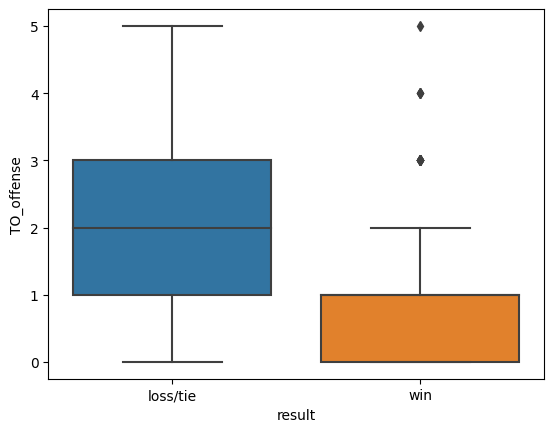

Index(['1stD_offense', 'TotYd_offense', 'PassY_offense', 'RushY_offense',
       'TO_offense', '1stD_defense', 'TotYd_defense', 'PassY_defense',
       'RushY_defense', 'TO_defense'],
      dtype='object')


In [5]:
# change stat value to view plot
stat = 'PassY_offense'

# box plot of stat
stat_plot = sns.boxplot(x='result', y=stat, data=nfl) 

# labels
stat_plot.set_xticklabels(['loss/tie','win'])
plt.show()

# list stat names
print(nfl.columns[8:])

## Data Preparation

### 5. Standardise features and Save game outcomes

To be useful in the regression I must standardise the game stats. This is so that I can compare them to one another as it isn't very helpful to directly compare the number of first downs to offensive passing yards. To solve this problem I standardise the stats so that they all have a mean of 0 and a standard deviation of 1. In Python I do this using the `sklearn` library. First I fit the `features` to the scaling function and then I use `scaler.transform()` to standardise the game stats, saving the final output to `X`.

I also save the game outcome variable to `y`.

In [6]:
# first I save the stats to the feature variables to be scaled
features = nfl.iloc[:,8:]
scaler = StandardScaler()

# fit the transformer to the features
scaler.fit(features)

# transform and save as X
X = scaler.transform(features)

In [7]:
# save result variable as y
y = nfl['result'] 

### 6. Training and Test data

As mentioned previously, the model needs some initial data to train itself and create the best fitting line. In this instance it is a good idea to randomly assign it some training data from the available data to avoid any potential bias. The remaining data will be used to check the accuracy of the model. 

The `train_test_split()` function from the `sklearn` library is useful here and I can use it to split the data randomly. This function splits up our input data into training data and testing data. In this instance I have set `test_size` to 0.5 and `random_state` to 42.

`test_size` is set to 0.5 to signify that half of the original data will be used as training data and the other half for testing.
`random_state` is set to 0 so that anyone running this notebook will get the same results as I did.

In [8]:
# create train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.5, random_state = 42)

## Analysis

### 7. Running the model

Now the model will train itself to recognise patterns in the game stats to predict the probability of winning a game, using `X_train` and `y_train`, our training data.


In [9]:
# creating the classifier
lrc = LogisticRegression()

# fit classifier to the training data
lrc.fit(X_train, y_train)

LogisticRegression()

### 8. Model accuracy

`lrc` is now fitted to the training data provided. I can now make predictions using the remaining test data. This is done by passing `X_test` as a parameter of `lrc.predict()`. The result will be saved in `y_pred`.

Now that I have predicted scores, I can check the accuracy of the model by comparing what it thought the outcome of a game should have been against what it actually was. The `accuracy_score()` function is useful here. I pass the actual game outcomes, `y_test`, and predicted game outcomes, `y_pred`, as parameters.

In [10]:
# predict outcomes using the test data
y_pred = lrc.predict(X_test)

# compare predicted results to actual to get accuracy score
accuracy_score(y_test, y_pred)

0.8280701754385965

As shown by the accuracy score, the model works well to predict outcomes of games. However there are still steps I can take to further improve the accuracy of this model.

### 9. Hyperparameter tuning

At this point I have to introduce two 'under the bonnet' components of the regression. The regression I am using implements two hyperparameters which instruct it on how to choose parameters and can be tuned to increase performance, these parameters being: `penalty` and `C`.

* The `penalty` parameter imposes a regularisation penalty on the model for having too many variables. This helps to determine which variables should be considered more strongly in the overall prediction.
* `C` is the inverse of regularisation strength. It applies a penalty to increasing the magnitude of parameter values in order to reduce overfitting. 

Below, I have written a for loop to test how different values of each hyperparameter affect the model accuracy.


In [11]:
# List of penalties
penalties = ['l1', 'l2']
# List of values for C
C = [0.01, 0.1, 1.0, 10.0, 1000.0]

for penalty in penalties:
    for c in C:

        # instantiate the classifier with the provided hyerparameters
        lrc_tuned = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

        # fit the classifier to the training data
        lrc_tuned.fit(X_train, y_train)
        
        # predict with the classifier using the .predict() function
        y_pred = lrc_tuned.predict(X_test)

        # view the model accuracy with the accuracy_score() function
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rd = round(accuracy*100,1)
        
        # print results for each combination of penalty and C
        print(f'Accuracy: {accuracy_rd}% | penalty = {penalty}, C = {c}')

Accuracy: 52.3% | penalty = l1, C = 0.01
Accuracy: 84.6% | penalty = l1, C = 0.1
Accuracy: 83.2% | penalty = l1, C = 1.0
Accuracy: 82.5% | penalty = l1, C = 10.0
Accuracy: 82.5% | penalty = l1, C = 1000.0
Accuracy: 80.4% | penalty = l2, C = 0.01
Accuracy: 83.5% | penalty = l2, C = 0.1
Accuracy: 82.8% | penalty = l2, C = 1.0
Accuracy: 82.5% | penalty = l2, C = 10.0
Accuracy: 82.5% | penalty = l2, C = 1000.0


Generally speaking the accuracy results were very similar. However, I can see that there does appear to be an optimum combination with `penalty = l1` and `C = 0.1`. This brings the model accuracy from 82.8% to 84.6% accuracy.

### 10. Test size optimisation

Hyperparameter tuning yielded some improvement to the model accuracy, but I can do better. Another method of improving the model accuracy is by adjusting the test size. 

I have written another for loop which cycles through various test sizes and computes the model accuracy using said test size. The output can be found below. 

In [12]:
# optimal penalty and C
penalty = 'l1'
C = 0.1

# List of test_sizes
test_sizes = [val/100 for val in range(20,36)]

for test_size in test_sizes:

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # instantiate the classifier with our optimal hyperparameters
    lrc_tts = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

    # fit the classifier to the training data
    lrc_tts.fit(X_train, y_train)

    # predict with the classifier using the .predict() function
    y_pred = lrc_tts.predict(X_test)

    # view the model accuracy with the accuracy_score() function
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_rd = round(accuracy*100,1)
    
    # print accuracy for each combination of penalty and test size
    print(f'Accuracy: {accuracy_rd}% | test size = {test_size}')

Accuracy: 87.7% | test size = 0.2
Accuracy: 87.5% | test size = 0.21
Accuracy: 87.3% | test size = 0.22
Accuracy: 87.9% | test size = 0.23
Accuracy: 88.3% | test size = 0.24
Accuracy: 88.8% | test size = 0.25
Accuracy: 87.9% | test size = 0.26
Accuracy: 88.3% | test size = 0.27
Accuracy: 88.1% | test size = 0.28
Accuracy: 88.6% | test size = 0.29
Accuracy: 87.1% | test size = 0.3
Accuracy: 87.6% | test size = 0.31
Accuracy: 86.9% | test size = 0.32
Accuracy: 87.3% | test size = 0.33
Accuracy: 86.1% | test size = 0.34
Accuracy: 86.0% | test size = 0.35


As can be seen by the results above, a test size of `0.25` yields the best results.

### 11. The optimised model

Now that I know which parameters optimise the model the final regression can be created and saved.

In [14]:
# optimised model parameters
test_size = 0.25
penalty = 'l1'
C = 0.1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# instantiate the classifier
optLr = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

# fit the classifier to the training data
optLr.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

### 12. Feature importance

As I mentioned previously, the model works to identify which stats are more important in determining wins. I can now look at how important the model thinks each individual stat is by creating a bar plot of the importance coefficients.

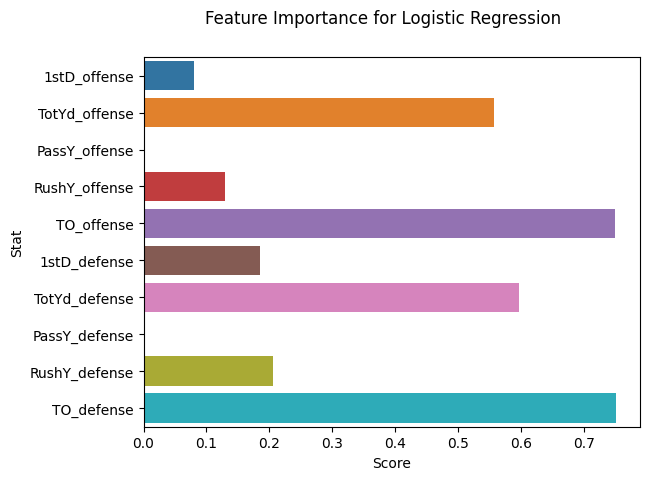

Feature: 1stD_offense, Score: 0.08
Feature: TotYd_offense, Score: 0.56
Feature: PassY_offense, Score: 0.0
Feature: RushY_offense, Score: 0.13
Feature: TO_offense, Score: 0.75
Feature: 1stD_defense, Score: 0.19
Feature: TotYd_defense, Score: 0.6
Feature: PassY_defense, Score: 0.0
Feature: RushY_defense, Score: 0.21
Feature: TO_defense, Score: 0.75


In [15]:
# get importance
importance = abs(optLr.coef_[0])

# visualize feature importance
sns.barplot(x=importance, y=features.columns)

# add labels and titles
plt.suptitle('Feature Importance for Logistic Regression')
plt.xlabel('Score')
plt.ylabel('Stat')
plt.show()


# summarize feature importance
for i,v in enumerate(importance.round(2)):
    print(f'Feature: {features.columns[i]}, Score: {v}')

It should come as no surprise to any NFL fans that the model thinks that turnovers, both `TO_offense` and `TO_defense`, are the most important stat in determining who wins a game. I say no surprise because turnovers are a huge turning point in a game and usually result in a team getting incredibly good field position which they can more easily turn into points. As my favourite sports debate show host, Shannon Sharpe, always says "Turnovers will get you beat", and boy do the stats show it. 

The results also show that as suspected the offensive passing yards seem to not be a very good indicator of a win or a loss, for reasons outlined in section 4.

## Conclusion

At this point I think I have to come clean, while the model above is quite accurate it isn't very helpful for me achieving my million dollar dreams. As I'm sure some of the keen eyed readers have already worked out, this model won't help you in predicting the future or assembling the perfect 'acca' (parlay for any American readers). This is due to the fact that the model predicts wins based off of stats from a game that have already happened, and are therefore not going to help make predictions before a game is played. One could build a model that does take into account statistics that are available before a game and you could go as deep down that rabbit hole as it goes, but for the purposes of my journey in programming and statistics I think this will do just fine!

Another confession I must make is that while this model won't make you a millionaire, it will help you identify some teams that are probably a little embarrassed with themselves over some of their game outcomes. So let's have a little look into that!

### 13. Using the model on the current NFL season stats

Below I have written a piece of code that uses the trained model above to predict wins in the current NFL season. So why don't we use this to find some teams that probably should've come away with a few more wins than they did. 

Any team can be evaluated here by changing the `team` variable to any team in the NFL. I've written a separate helper script which will allow you to import and use `get_new_data()`, this will pull new data for a given year from the Pro Football website [Pro Football Reference](https://www.pro-football-reference.com/).

In [54]:
# set team and year
team = 'Buffalo Bills'
year = 2022

# Function to pull new data
from helper import get_new_data
new_data = get_new_data(team=team, year=year)

# view head of new data
new_data.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Buffalo Bills,1,Thu,September 8,1,Los Angeles Rams,31,10,23,413,292,121,4,19,243,191,52,3
1,Buffalo Bills,2,Mon,September 19,1,Tennessee Titans,41,7,23,414,313,101,0,12,187,107,80,4
2,Buffalo Bills,3,Sun,September 25,0,Miami Dolphins,19,21,31,497,382,115,1,15,212,171,41,0
3,Buffalo Bills,4,Sun,October 2,1,Baltimore Ravens,23,20,22,326,201,125,2,22,296,134,162,2
4,Buffalo Bills,5,Sun,October 9,1,Pittsburgh Steelers,38,3,21,552,432,120,2,23,364,310,54,2


Just as before the data must be standardised before it can be used.

In [55]:
# select just the game stats
new_X = new_data.loc[:,features.columns]

# standardise using original data's scaling
new_X_sc = scaler.transform(new_X)

The data is ready. Predictions can now be made and an accuracy score calculated.

In [56]:
# get new predictions
new_preds = optLr.predict(new_X_sc)

# get actual results and set type to float
new_results = new_data['result'].astype(float)

# get accuracy score for new data
acc_score = accuracy_score(new_results, new_preds)

Let's put all this information together in a table and print out the accuracy score.

In [57]:
# select game data
col_names = ['day', 'date', 'result', 'opponent', 'tm_score', 'opp_score']
game_data = new_data.loc[:,col_names]
# create table
comp_table = game_data.assign(predicted = new_preds,
                              actual = new_results.astype(int))

In [58]:
# print title and table
print(f'Predicted Wins vs Actual for {team} in {year}')
comp_table

Predicted Wins vs Actual Wins for Buffalo Bills in 2022


,day,date,result,opponent,tm_score,opp_score,predicted,actual
0,Thu,September 8,1,Los Angeles Rams,31,10,1,1
1,Mon,September 19,1,Tennessee Titans,41,7,1,1
2,Sun,September 25,0,Miami Dolphins,19,21,1,0
3,Sun,October 2,1,Baltimore Ravens,23,20,1,1
4,Sun,October 9,1,Pittsburgh Steelers,38,3,1,1
5,Sun,October 16,1,Kansas City Chiefs,24,20,1,1
6,Sun,October 30,1,Green Bay Packers,27,17,0,1
7,Sun,November 6,0,New York Jets,17,20,0,0


In [59]:
# print accuracy
print(f'\nCurrent Accuracy Score: ' + str(round(acc_score*100,1)) + '%')


Current Accuracy Score: 75.0%


In the example above I have selected the Buffalo Bills, we can see that generally the Bills achieved the outcome predicted by the model. However, I'd like to draw everyone's attention to October 30th when the Buffalo Bills played my beloved Green Bay Packers. The model predicted a loss for the Buffalo Bills but they managed to get a win. The reason I point to this game in particular is even though I haven't looked directly at the statistics of the game myself, I did happen to watch it live. The real story of that game was the Green Bay Packers had lost faith in their young group of receivers and leading up to the game decided to place the trust not in the hands of the back-to-back NFL MVP, Aaron Rodgers, but instead in the hands of their running backs. This plan ultimately failed as the Packers kept having to punt to the Bills after lengthy possessions and ultimately lost. On the stat sheet however, the Packers possessed the ball for far longer than the Bills, and most importantly due to their no risk approach had a much better turnover difference than the Bills. As seen previously this model puts incredible emphasis on turnovers, and rightfully so. However, on this occasion the model really could've used with a simple pair of eyes. 